# Neural Networks (2025-01):  Homework 1
(Due: 2025.4.29 11:59 pm)

**Formatting: please include both a .ipynb and .pdf file in your homework submission, named studentID_homework1.ipynb and studentID_homework1.pdf.  Please don't change the filename.**       


In my case, there were version mismatches between torch, python and torchvision. For stable version versions of torch and torchvision, see [here](https://pypi.org/project/torchvision/). You may upgrade or downgrade one or more libraries to properly start your project. For example, I needed to downgrade the version of torchvision to v0.19.

In [129]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


Check your gpu is properly working. If you are given False after runnig the cell below, change your runtime to gpu (Go to Menu > Runtime > Change runtime).

In [120]:
import torch
torch.cuda.is_available()

True

# 1. Logistic Regression for Binary Classification

In multiclass classification we typically use the: exponential model

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1.1. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$

임의로 $o_{-1} = 0$으로 설정하고, $o = o_1$라고 하면,


$$p(y = 1 | o) = \frac{\exp(o)}{\exp(0)+\exp(o)} = \frac{\exp(o)*\exp(-o)}{\exp(0)*\exp(-o)+\exp(o)*\exp(-o)} = \frac{1}{1 + \exp(-o)}$$

$$softmax(o) = \frac{1}{1 + \exp(-o)}$$

1.2. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

$$p(y=1|o_1) = \frac{1}{1+\exp(-o_1)} = \frac{1}{1+\exp((-1*o_1)}$$
$$p(y= -1|o_{-1})) = \frac{1}{1+\exp(o_{-1})} = \frac{1}{1+\exp((-(-1)*o_{-1})}$$
$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

Now, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on.

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt

# Pre-defined libraries in Pytorch
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.init
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

mnist_train = datasets.FashionMNIST(root='MNIST_data/',train=True, download=True)
mnist_test = datasets.FashionMNIST(root='MNIST_data/',train=False, download=True)

## 2. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$.

In [2]:
def logistic_loss(y,o):
    ## add your loss function here
    l = -torch.log(1 + torch.exp(-y * o))
    return l

2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation.

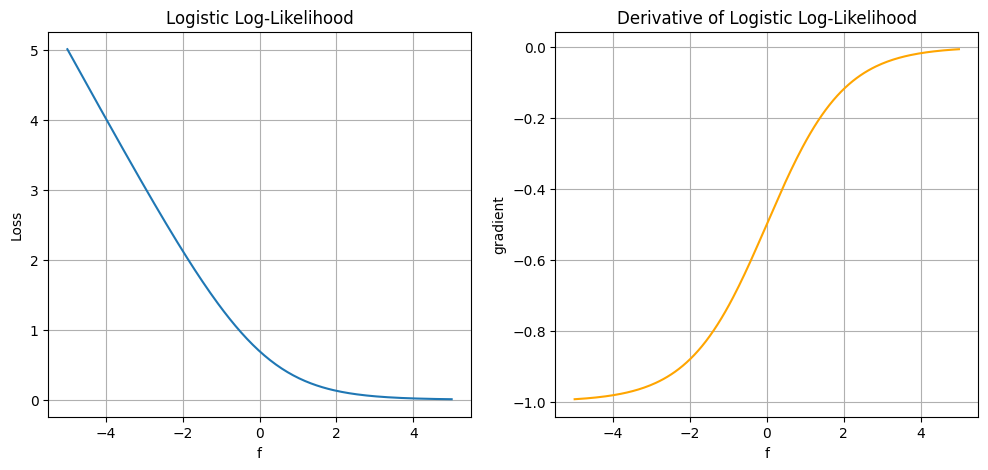

In [3]:
f = torch.linspace(-5, 5, steps=200, requires_grad=True)
y = torch.ones_like(f)
loss = -logistic_loss(y, f)

loss.sum().backward()
gradient = f.grad

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(f.detach(), loss.detach())
plt.title("Logistic Log-Likelihood")
plt.xlabel("f")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(f.detach(), gradient.detach(), color='orange')
plt.title("Derivative of Logistic Log-Likelihood")
plt.xlabel("f")
plt.ylabel("gradient")
plt.grid(True)

plt.show()

3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `sneaker` and `pullover` and class $-1$ being the combination of `sandal` and `shirt` categories.

In [4]:
for i, v in enumerate(mnist_train.classes):
    print(i, v)

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot


In [5]:
# mapping class, set label
# sneaker: 7, pullover: 2 -> +1
# sandal: 5, shirt: 6 -> -1
class_map = {2: 1, 7: 1, 5: -1, 6: -1}

def filter_and_label(dataset):
    all_labels = np.array(dataset.targets)
    all_images = dataset.data  # shape: (60000, 28, 28)
    selected_mask = np.isin(all_labels, list(class_map.keys()))
    
    filtered_images = all_images[selected_mask]
    filtered_raw_labels = all_labels[selected_mask]  # 원본 라벨 (2, 5, 6, 7)
    filtered_binary_labels = np.vectorize(class_map.get)(filtered_raw_labels)

    return filtered_images, filtered_binary_labels, filtered_raw_labels

train_images, train_labels, train_raw_labels = filter_and_label(mnist_train)
test_images, test_labels, test_raw_labels = filter_and_label(mnist_test)

print("Train:", np.unique(train_labels, return_counts=True))
print("Test:", np.unique(test_labels, return_counts=True))

Train: (array([-1,  1]), array([12000, 12000]))
Test: (array([-1,  1]), array([2000, 2000]))


In [6]:
len([i for i, l in enumerate(train_labels) if l == 1])

12000

4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy.

In [42]:
class BinaryMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.reset_parameters()

    def forward(self, x):
        return self.model(x)

    def reset_parameters(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                m.reset_parameters()

In [43]:
def logistic_loss(y, o):
    l = torch.mean(torch.log1p(torch.exp(-y * o)))
    return l

In [44]:
def train(model, image_data, label_data, indices, optimizer, device):
    model.train()
    total_loss = 0
    batch_size = 64
    for i in range(0, len(indices), batch_size):
        idxs = indices[i:i + batch_size]
        x = torch.stack([image_data[j].float().view(-1) / 255.0 for j in idxs]).to(device)
        y = torch.tensor([label_data[j] for j in idxs], dtype=torch.float32).view(-1, 1).to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = logistic_loss(y, output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / (len(indices) // batch_size)

def test(model, image_data, label_data, device):
    model.eval()
    correct, total = 0, 0
    batch_size = 64
    with torch.no_grad():
        for i in range(0, len(image_data), batch_size):
            idxs = range(i, min(i + batch_size, len(image_data)))
            x = torch.stack([image_data[j].float().view(-1) / 255.0 for j in idxs]).to(device)
            y = torch.tensor([label_data[j] for j in idxs], dtype=torch.float32).view(-1, 1).to(device)
            output = model(x)
            pred = (torch.sigmoid(output) > 0.5).float()
            correct += (pred == ((y + 1) / 2)).sum().item()
            total += y.size(0)
    return correct / total


In [45]:
def run_experiment(indices, description):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BinaryMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        loss = train(model, train_images, train_labels, indices, optimizer, device)
        acc = test(model, test_images, test_labels, device)
        print(f"[{description}] Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

all_indices = list(range(len(train_images)))
half_indices = all_indices[:12000]

print("Half Dataset")
run_experiment(half_indices, "Half Dataset")
print("\nFull Dataset")
run_experiment(all_indices, "Full Dataset")

Half Dataset
[Half Dataset] Epoch 1: Loss=0.3888, Accuracy=0.8738
[Half Dataset] Epoch 2: Loss=0.2575, Accuracy=0.8780
[Half Dataset] Epoch 3: Loss=0.2241, Accuracy=0.8895
[Half Dataset] Epoch 4: Loss=0.2074, Accuracy=0.9002
[Half Dataset] Epoch 5: Loss=0.1951, Accuracy=0.9022

Full Dataset
[Full Dataset] Epoch 1: Loss=0.3249, Accuracy=0.9012
[Full Dataset] Epoch 2: Loss=0.2251, Accuracy=0.9117
[Full Dataset] Epoch 3: Loss=0.2026, Accuracy=0.9175
[Full Dataset] Epoch 4: Loss=0.1899, Accuracy=0.9190
[Full Dataset] Epoch 5: Loss=0.1788, Accuracy=0.9225


전체 데이터를 사용한 경우가 모든 epoch에서 더 낮은 손실값과 더 높은 정확도를 기록

결론적으로, 학습 데이터의 양이 많을수록 분류 성능이 일관되게 향상됨을 확인

## 3. Covariate Shift
Your goal is to introduce covariate shift in the data and observe the accuracy. For this, compose a dataset of  12,000  observations, given by a mixture of sneaker and pullover and of sandal and shirt respectively, where you use a fraction  λ∈{0.05,0.1,0.2,…0.8,0.9,0.95}  of one and a fraction of  1−λ  of the other datasets respectively. For instance, you might pick for  λ=0.1  a total of  600  sneaker and  5,400  pullover images and likewise  600  sandal and  5,400  shirt photos, yielding a total of  12,000  images for training. Note that the test set remains unbiased, composed of  2,000  photos for the sneaker + pullover category and of the sandal + shirt category each.

Generate training sets that are appropriately biased. You should have 11 datasets.
Train a binary classifier using this and report the test set accuracy on the unbiased test set.

In [51]:
import random
# if λ == 0.1 then:
# sneaker: 7, pullover: 2 -> +1 / sneaker: 600ea, pullover: 5,400ea 
# sandal: 5, shirt: 6 -> -1 / sandal: 600ea, shirt 5,400ea
# 한쪽 클래스당 6,000개 유지

sneaker_idx  = [i for i, (y, r) in enumerate(zip(train_labels, train_raw_labels)) if y == 1 and r == 7]
pullover_idx = [i for i, (y, r) in enumerate(zip(train_labels, train_raw_labels)) if y == 1 and r == 2]
sandal_idx   = [i for i, (y, r) in enumerate(zip(train_labels, train_raw_labels)) if y == -1 and r == 5]
shirt_idx    = [i for i, (y, r) in enumerate(zip(train_labels, train_raw_labels)) if y == -1 and r == 6]

lambda_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# lambda_list = [0.1]
results = {}

for lamb in lambda_list:
    size = 6000
    n_lambda = int(size * lamb)
    n_1_minus_lambda  = size - n_lambda

    pos_idx = sneaker_idx[:n_lambda] + pullover_idx[:n_1_minus_lambda]
    neg_idx = sandal_idx[:n_lambda] + shirt_idx[:n_1_minus_lambda]
    train_idx = pos_idx + neg_idx

    print(f"\nλ = {lamb:.2f} | +1: (sneaker={n_lambda}, pullover={n_1_minus_lambda}), -1: (sandal={n_lambda}, shirt={n_1_minus_lambda})")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BinaryMLP().to(device)
    model.reset_parameters()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        random.shuffle(train_idx)
        loss = train(model, train_images, train_labels, train_idx, optimizer, device)
        acc = test(model, test_images, test_labels, device)
        print(f"  Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")
    
    results[lamb] = acc


λ = 0.05 | +1: (sneaker=300, pullover=5700), -1: (sandal=300, shirt=5700)
  Epoch 1: Loss=0.4613, Accuracy=0.8495
  Epoch 2: Loss=0.3560, Accuracy=0.8838
  Epoch 3: Loss=0.3128, Accuracy=0.8900
  Epoch 4: Loss=0.2950, Accuracy=0.8932
  Epoch 5: Loss=0.2702, Accuracy=0.8965

λ = 0.10 | +1: (sneaker=600, pullover=5400), -1: (sandal=600, shirt=5400)
  Epoch 1: Loss=0.4694, Accuracy=0.8695
  Epoch 2: Loss=0.3546, Accuracy=0.8762
  Epoch 3: Loss=0.3127, Accuracy=0.8968
  Epoch 4: Loss=0.2877, Accuracy=0.9050
  Epoch 5: Loss=0.2668, Accuracy=0.9012

λ = 0.20 | +1: (sneaker=1200, pullover=4800), -1: (sandal=1200, shirt=4800)
  Epoch 1: Loss=0.4412, Accuracy=0.8692
  Epoch 2: Loss=0.3240, Accuracy=0.8972
  Epoch 3: Loss=0.2899, Accuracy=0.9002
  Epoch 4: Loss=0.2646, Accuracy=0.9080
  Epoch 5: Loss=0.2614, Accuracy=0.8988

λ = 0.30 | +1: (sneaker=1800, pullover=4200), -1: (sandal=1800, shirt=4200)
  Epoch 1: Loss=0.4317, Accuracy=0.8738
  Epoch 2: Loss=0.3110, Accuracy=0.8950
  Epoch 3: Loss=

In [52]:
len(train_idx)

12000

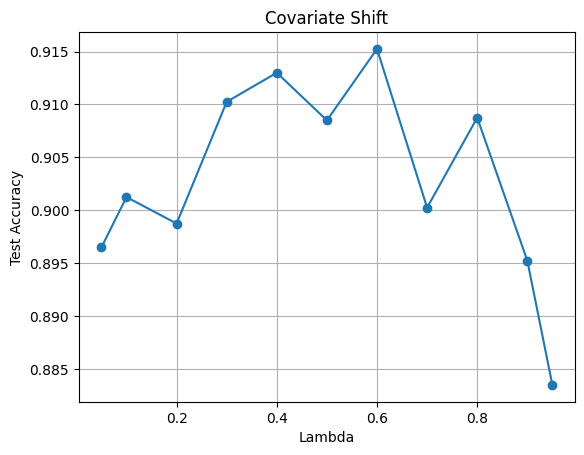

In [53]:
lambdas = sorted(results.keys())
accuracies = [results[l] for l in lambdas]

# plt.figure(figsize=(8, 5))
plt.plot(lambdas, accuracies, marker='o')
plt.title('Covariate Shift')
plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

λ를 변화시키며 학습 데이터의 클래스 구성 비율을 조절한 결과,

소수 클래스가 존재하는 편향된 데이터에서도 일정 수준 이상의 분류 성능을 유지할 수 있음을 확인

(처음에는 학습이 잘 안되었으나, random.shuffle(train_idx)을 추가함으로써 한 배치 안에 클래스가 몰려있는걸 방지)

λ = 0.5 인근에서 acc가 높음을 확인

## 4. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?



Covariate shift란, train distribution $P_{train}(x)$와 test distribution $P_{test}(x)$가 다른 경우를 말함

특히 학습 데이터와 테스트 데이터의 사이즈가 다르면, 표본 비율이 test 세트의 실제 분포를 제대로 반영하지 못하게 됨

따라서, train 데이터 포인트 하나하나에 weight를 곱해서 train 데이터의 분포를 test 분포처럼 보정해줘야함

x에 대해 적용할 weight는 :
$$w(x)=\frac{N_{train}}{N_{test}}\exp(f(x))$$

f(x)는 train/test를 구분하는 binary classifier의 출력이고,

exp(f(x))는 "test가 될 확률" 대 "train이 될 확률" 비율

${N_{train}}/{N_{test}}$는 샘플 수 차이를 보정하는 계수

2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data.

In [97]:
class LogisticBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 1)

    def forward(self, x):
        return self.linear(x)

In [98]:
results = []
lamb = 0.95
size = 6000
n_lambda = int(size * lamb)
n_1_minus_lambda = size - n_lambda

pos_idx = sneaker_idx[:n_lambda] + pullover_idx[:n_1_minus_lambda]
neg_idx = sandal_idx[:n_lambda] + shirt_idx[:n_1_minus_lambda]
train_idx = pos_idx + neg_idx

print(f"\nλ = {lamb:.2f} | +1: (sneaker={n_lambda}, pullover={n_1_minus_lambda}), -1: (sandal={n_lambda}, shirt={n_1_minus_lambda})")

# Binary Classifier for covariate shift
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.stack([train_images[i].float().view(-1) / 255.0 for i in train_idx])
y_train = torch.zeros(len(train_idx))  # 0

x_test = torch.stack([test_images[i].float().view(-1) / 255.0 for i in range(len(test_images))])
y_test = torch.ones(len(test_images))  # 1

X = torch.cat([x_train, x_test], dim=0).to(device) #train + test feature
Y = torch.cat([y_train, y_test], dim=0).view(-1, 1).to(device) # train + test label

binary_classifier = LogisticBinaryClassifier().to(device)
optimizer_bc = optim.Adam(binary_classifier.parameters(), lr=0.001)
loss_fn_bc = nn.BCEWithLogitsLoss()

# train binary classifier
for epoch in range(20):
    binary_classifier.train()
    optimizer_bc.zero_grad()
    output = binary_classifier(X)
    loss = loss_fn_bc(output, Y)
    loss.backward()
    optimizer_bc.step()
    print(f"[Binary Classifier] Epoch {epoch+1}, Loss={loss.item():.4f}")

# Calculate w(x)
binary_classifier.eval()
with torch.no_grad():
    f_x = binary_classifier(X).squeeze()

n_train = len(train_idx)
n_test = len(test_images)
scale = n_train / n_test

weights_all = scale * torch.exp(f_x)  # 전체 weight (train + test)

# train 데이터에 해당하는 weight만 추출
weights_train = weights_all[:len(train_idx)]

# train Re-weighted
model = LogisticBinaryClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss(reduction='none')

for epoch in range(20):
    # train_idx와 weights_train을 같이 셔플
    combined = list(zip(train_idx, weights_train))
    random.shuffle(combined)
    train_idx, shuffled_weights_train = zip(*combined)
    train_idx = list(train_idx)
    shuffled_weights_train = torch.stack(shuffled_weights_train).to(device)

    model.train()

    total_loss = 0
    batch_size = 64
    for i in range(0, len(train_idx), batch_size):
        idxs = train_idx[i:i + batch_size]
        x = torch.stack([train_images[j].float().view(-1) / 255.0 for j in idxs]).to(device)
        y = torch.tensor([train_labels[j] for j in idxs], dtype=torch.float32).view(-1, 1).to(device)
        batch_weights = shuffled_weights_train[i:i + batch_size].view(-1, 1)

        optimizer.zero_grad()
        output = model(x)
        y_target = (y + 1) / 2
        loss = loss_fn(output, y_target)
        weighted_loss = (batch_weights * loss).mean()
        weighted_loss.backward()
        optimizer.step()

        total_loss += weighted_loss.item()

    avg_loss = total_loss / (len(train_idx) // batch_size)
    acc = test(model, test_images, test_labels, device)
    print(f"[Reweighted Training] Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc:.4f}")


λ = 0.95 | +1: (sneaker=5700, pullover=300), -1: (sandal=5700, shirt=300)
[Binary Classifier] Epoch 1, Loss=0.6787
[Binary Classifier] Epoch 2, Loss=0.6523
[Binary Classifier] Epoch 3, Loss=0.6286
[Binary Classifier] Epoch 4, Loss=0.6075
[Binary Classifier] Epoch 5, Loss=0.5889
[Binary Classifier] Epoch 6, Loss=0.5725
[Binary Classifier] Epoch 7, Loss=0.5581
[Binary Classifier] Epoch 8, Loss=0.5455
[Binary Classifier] Epoch 9, Loss=0.5346
[Binary Classifier] Epoch 10, Loss=0.5250
[Binary Classifier] Epoch 11, Loss=0.5167
[Binary Classifier] Epoch 12, Loss=0.5096
[Binary Classifier] Epoch 13, Loss=0.5034
[Binary Classifier] Epoch 14, Loss=0.4981
[Binary Classifier] Epoch 15, Loss=0.4936
[Binary Classifier] Epoch 16, Loss=0.4899
[Binary Classifier] Epoch 17, Loss=0.4868
[Binary Classifier] Epoch 18, Loss=0.4844
[Binary Classifier] Epoch 19, Loss=0.4824
[Binary Classifier] Epoch 20, Loss=0.4808
[Reweighted Training] Epoch 1: Loss=0.6437, Accuracy=0.7522
[Reweighted Training] Epoch 2: Los

3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$?

In [100]:
sneaker_weights = []
pullover_weights = []
sandal_weights = []
shirt_weights = []

for idx, w in zip(train_idx, weights_train):
    label = train_raw_labels[idx]
    if label == 7:
        sneaker_weights.append(w.item())
    elif label == 2:
        pullover_weights.append(w.item())
    elif label == 5:
        sandal_weights.append(w.item())
    elif label == 6:
        shirt_weights.append(w.item())

print("Average weight by class:")
print(f"Sneaker (7) : {np.mean(sneaker_weights):.4f}")
print(f"Pullover (2): {np.mean(pullover_weights):.4f}")
print(f"Sandal (5)  : {np.mean(sandal_weights):.4f}")
print(f"Shirt (6)   : {np.mean(shirt_weights):.4f}")

Average weight by class:
Sneaker (7) : 1.1920
Pullover (2): 1.1183
Sandal (5)  : 1.1889
Shirt (6)   : 1.2619


이진 분류기를 편향된 훈련 세트와 편향되지 않은 테스트 세트를 구분하도록 훈련시킨 후, 출력 점수를 사용하여 가중치 w(x)를 계산

희귀한 pullover, shirt의 w(x)가 커야 하고

흔한 sneaker, sandal의 w(x)가 작아야 함

pullover와 shirt가 sneaker, sandal보다 w(x)가 높다

이는 계산된 가중치가 λ에 의해 유도된 편향과 일치

4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses.

In [101]:
# init binary classifier
binary_classifier = LogisticBinaryClassifier().to(device)
optimizer_bc = optim.Adam(binary_classifier.parameters(), lr=0.001)
loss_fn_bc = nn.BCEWithLogitsLoss(reduction='none')

# train
for epoch in range(20):
    binary_classifier.train()
    total_loss = 0
    batch_size = 64
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = Y[i:i+batch_size]
        w_batch = weights_all[i:i+batch_size].view(-1, 1)

        optimizer_bc.zero_grad()
        output = binary_classifier(x_batch)
        loss = loss_fn_bc(output, y_batch)
        weighted_loss = (w_batch * loss).mean()
        weighted_loss.backward()
        optimizer_bc.step()

        total_loss += weighted_loss.item()

    avg_loss = total_loss / (len(X) // batch_size)
    print(f"[Reweighted Binary Classifier] Epoch {epoch+1}: Loss={avg_loss:.4f}")

# test
binary_classifier.eval()
with torch.no_grad():
    output = binary_classifier(X)
    pred = (torch.sigmoid(output) > 0.5).float()
    acc = (pred == Y).float().mean().item()
    print(f"Accuracy after reweighted training: {acc:.4f}")

[Reweighted Binary Classifier] Epoch 1: Loss=3.2597
[Reweighted Binary Classifier] Epoch 2: Loss=1.4870
[Reweighted Binary Classifier] Epoch 3: Loss=1.3659
[Reweighted Binary Classifier] Epoch 4: Loss=1.3800
[Reweighted Binary Classifier] Epoch 5: Loss=1.3840
[Reweighted Binary Classifier] Epoch 6: Loss=1.3865
[Reweighted Binary Classifier] Epoch 7: Loss=1.3873
[Reweighted Binary Classifier] Epoch 8: Loss=1.3871
[Reweighted Binary Classifier] Epoch 9: Loss=1.3864
[Reweighted Binary Classifier] Epoch 10: Loss=1.3853
[Reweighted Binary Classifier] Epoch 11: Loss=1.3840
[Reweighted Binary Classifier] Epoch 12: Loss=1.3826
[Reweighted Binary Classifier] Epoch 13: Loss=1.3811
[Reweighted Binary Classifier] Epoch 14: Loss=1.3797
[Reweighted Binary Classifier] Epoch 15: Loss=1.3783
[Reweighted Binary Classifier] Epoch 16: Loss=1.3770
[Reweighted Binary Classifier] Epoch 17: Loss=1.3757
[Reweighted Binary Classifier] Epoch 18: Loss=1.3745
[Reweighted Binary Classifier] Epoch 19: Loss=1.3733
[R

covariate shift가 존재한다는것을 binary classifier가 어느 정도 포착